In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.svm import SVC
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier

sns.set_theme()


SEED = 357

random.seed(SEED)
np.random.seed(SEED)

In this notebook we will work on dataset related to early stage diabetes risk prediction.

[https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.](https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.)


In [2]:
data = pd.read_csv('data/diabetes_data_upload.csv')

In [3]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


The data consists of age, gender, and 14 binary features related to things like delayed healing, visual blurring, itching, etc.

In [4]:
data.isnull().values.any()

False

Nextly we split data into train and test parts stratified by class and gender.

In [5]:
x = data.drop('class', axis=1).to_numpy()
y = data['class'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y + x[:, 1])

Check the proportions of gender/class

In [6]:
for gender in ['Male', 'Female']:
    for cls in ['Negative', 'Positive']:
        print(gender, cls, np.sum((x_train[:, 1] == gender) & (y_train == cls)))

Male Negative 145
Male Positive 118
Female Negative 15
Female Positive 138


There is a shortage of Female Negatives examples, so there is a possibility that classifier will focus on gender feature, increasing its probability of outputting 'Positive' class, if the gender in question is female.

The classifiers expects data to be in numerical format, so we must transform it. We will also binarize the age feature into 7 distinctive bins.

In [7]:
discretizer_age = KBinsDiscretizer(n_bins=7, encode='ordinal')
x_train[:, 0:1] = discretizer_age.fit_transform(x_train[:, 0:1])

encoder_features = OrdinalEncoder(categories=[['Male', 'Female']] + 14 * [['No', 'Yes']])
x_train[:, 1:] = encoder_features.fit_transform(x_train[:, 1:])

encoder_labels = LabelEncoder()
y_train = encoder_labels.fit_transform(y_train)

The first classifier to try is a simple logistic one.

In [8]:
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1e5))
])

parameters = {
    'clf__C': np.logspace(-6, 5, num=50)
}

In [9]:
cv = GridSearchCV(deepcopy(estimator), parameters, scoring='accuracy', refit=True)
cv.fit(x_train, y_train)
print(cv.best_score_)

0.9325588066551921


In [10]:
x_test[:, 0:1] = discretizer_age.transform(x_test[:, 0:1])
x_test[:, 1:] = encoder_features.transform(x_test[:, 1:])
y_test = encoder_labels.transform(y_test)

We can learn which features the classifier is looking for the most by plotting learned coefficients.

<BarContainer object of 16 artists>

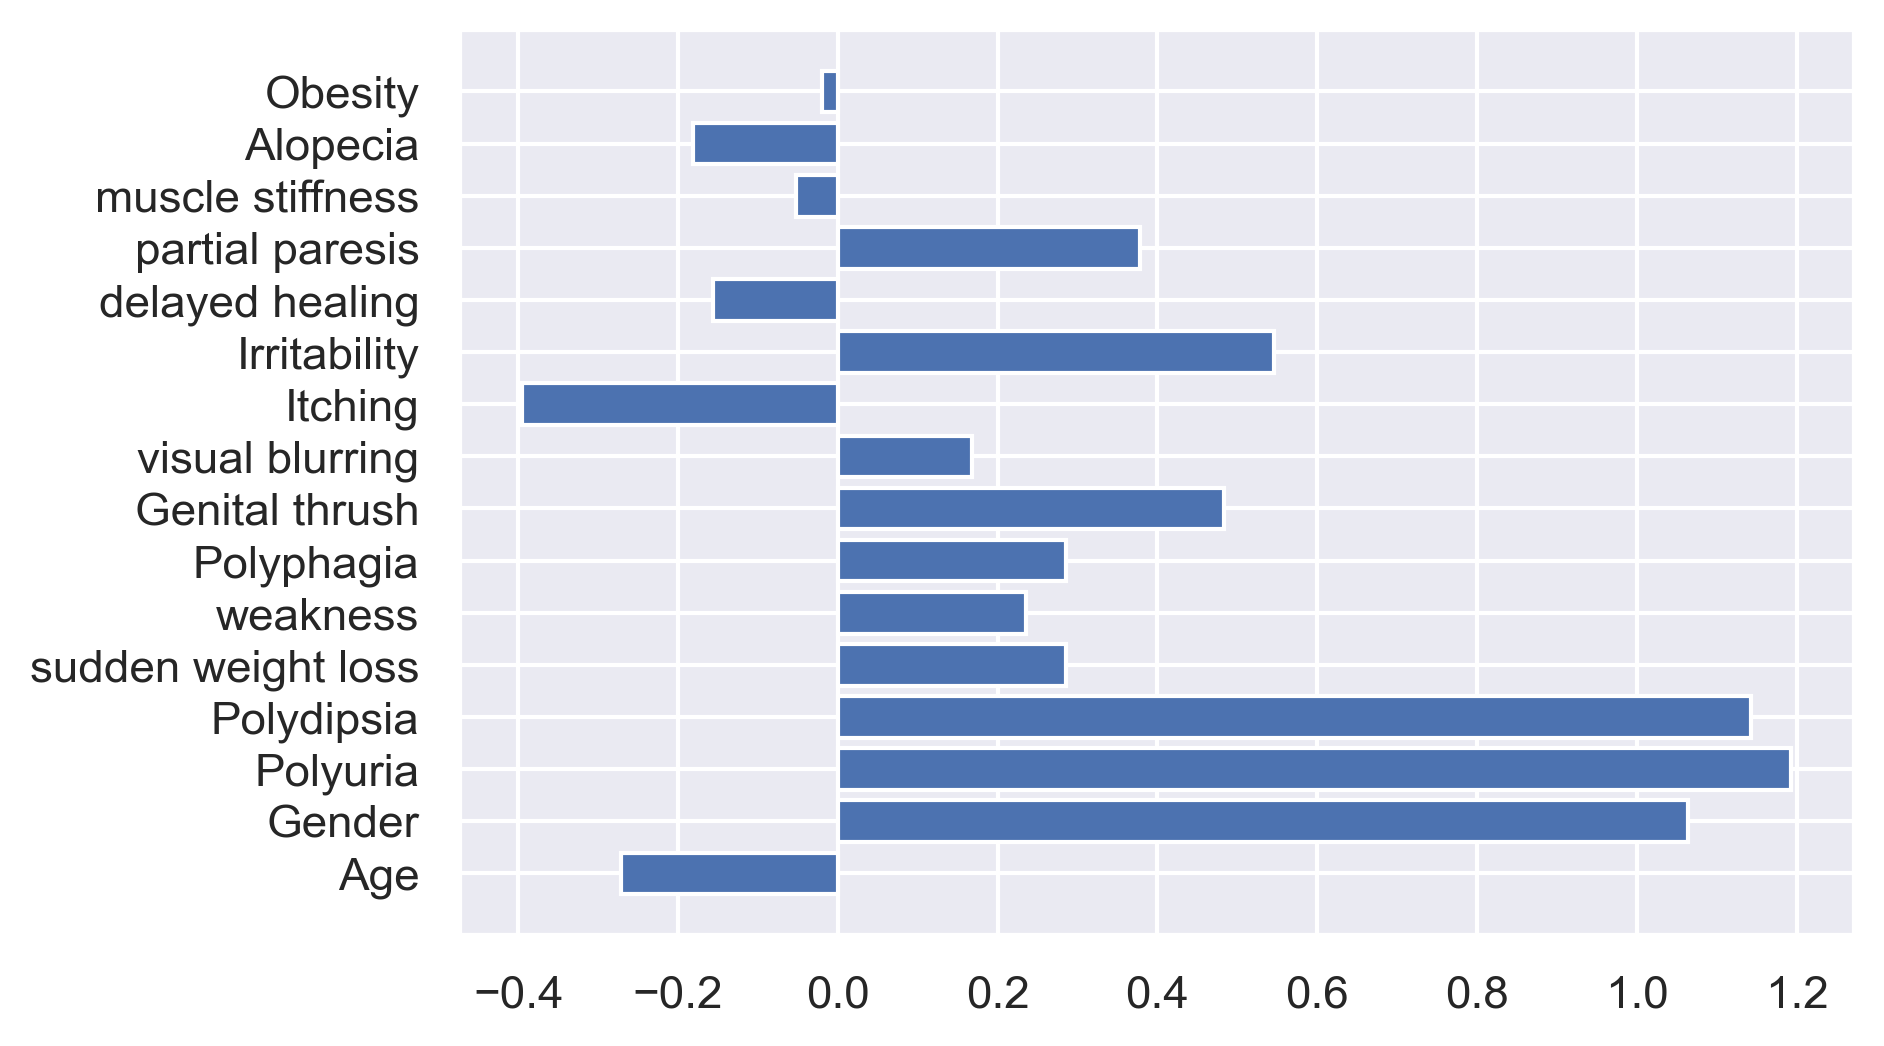

In [11]:
plt.figure(dpi=300)
plt.barh(y=data.columns[:-1], width=cv.best_estimator_['clf'].coef_.squeeze())

We see that gender is very discriminative feature. This is, as we said earlier, the result of negative class distribution among genders.

Remove gender feature and redo classification.

In [12]:
x_train = np.delete(x_train, 1, 1)
x_test = np.delete(x_test, 1, 1)

In [13]:
cv = GridSearchCV(deepcopy(estimator), parameters, scoring='accuracy', refit=True)
cv.fit(x_train, y_train)
print(cv.best_score_)

0.8774526678141136


<BarContainer object of 15 artists>

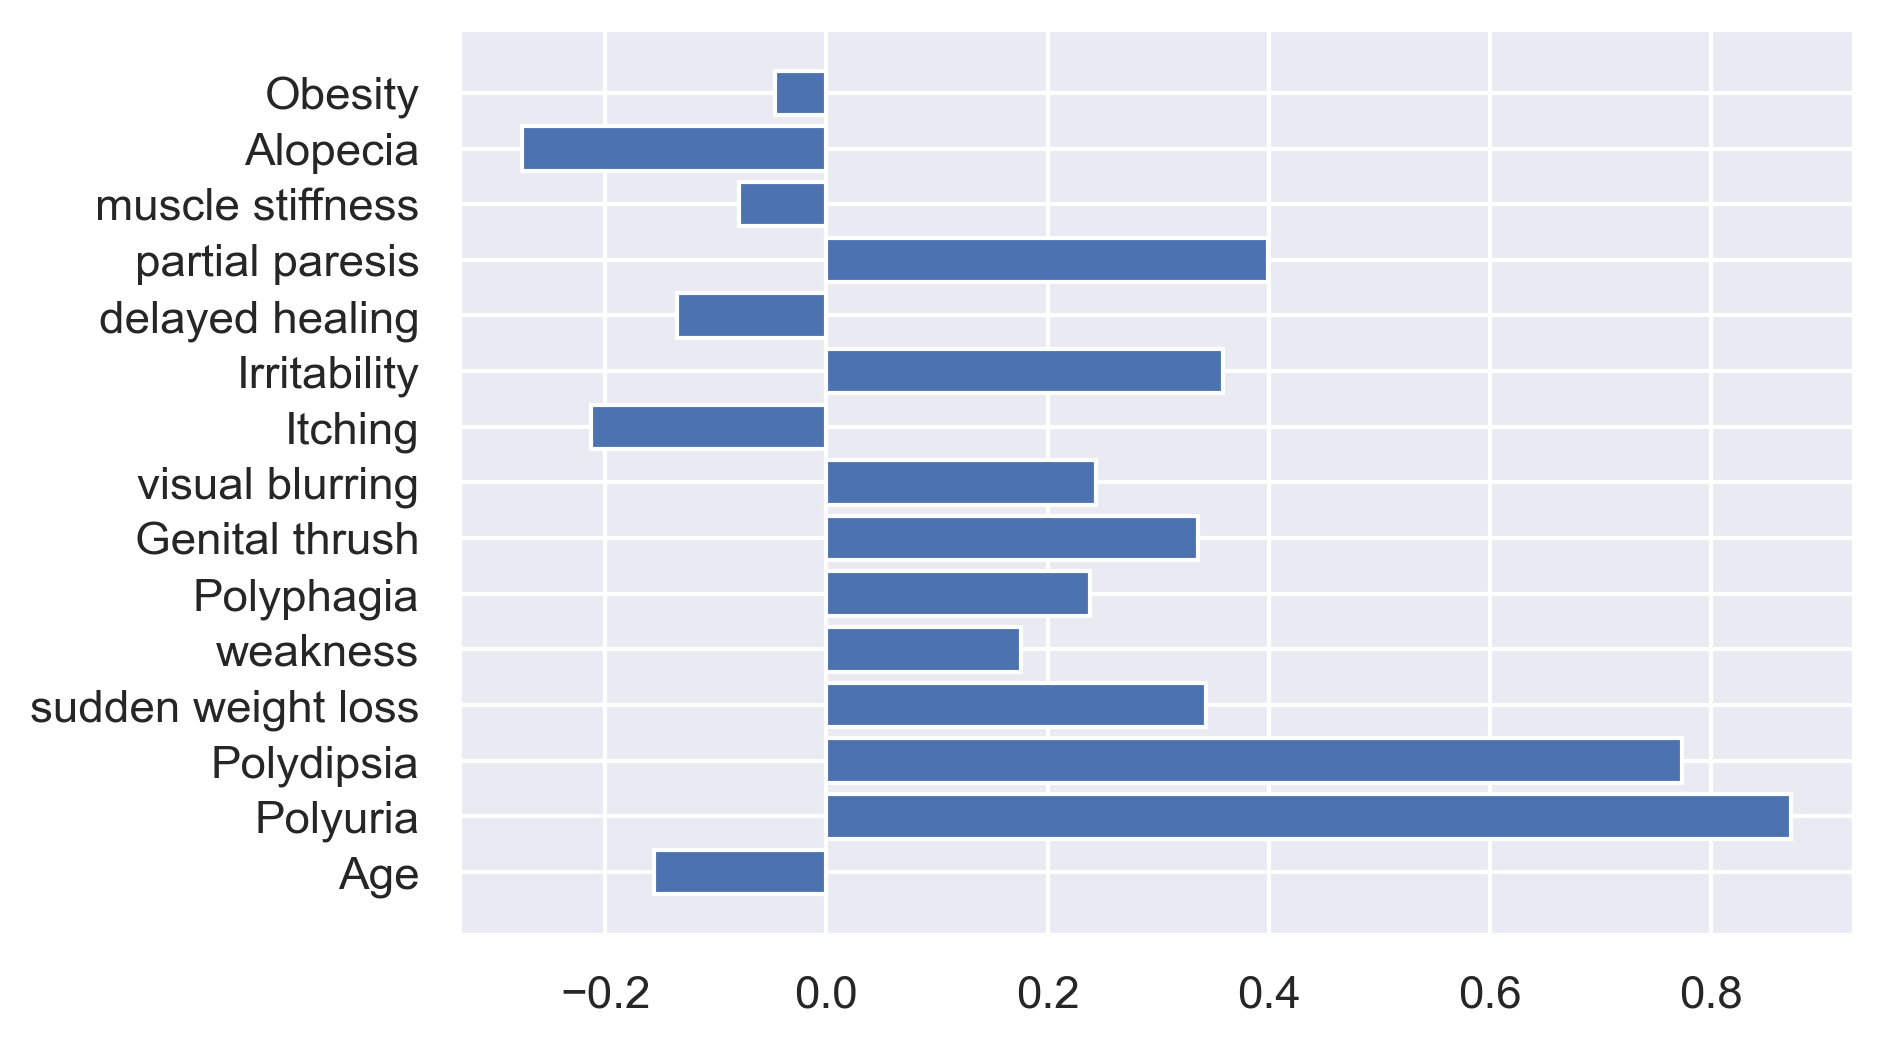

In [14]:
plt.figure(dpi=300)
plt.barh(y=data.columns[:-1].delete(1), width=cv.best_estimator_['clf'].coef_.squeeze())

Feature importance distribution haven't changed much. Visual blurring, partial paresis become more important for positive early stage diabetes prediction and alopecia less.

Let's run another two types of classifiers.

In [15]:
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

parameters = {
    'clf__C': np.logspace(-7, 4, num=10),
    'clf__gamma': np.logspace(-3, 8, num=10),
}

cv = GridSearchCV(deepcopy(estimator), parameters, scoring='accuracy', refit=True)
cv.fit(x_train, y_train)
print(cv.best_score_)

0.9615318416523235


In [16]:
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
])

parameters = {
    'clf__n_estimators': [20, 50, 100, 150],
}

cv = GridSearchCV(deepcopy(estimator), parameters, scoring='accuracy', refit=True)
cv.fit(x_train, y_train)
print(cv.best_score_)

0.963970166379805


By comparing cross validation best scores, Random Forest classifier is chosen. The final performance on the unseen data will be evaluated by using him.

In [17]:
print(f"accuracy on test set without gender: {accuracy_score(y_test, cv.predict(x_test)) * 100:.2f}%")

accuracy on test set without gender: 96.15%


Summary:
- We are able to construct classifier that has high accuracy on unseen data
- The most important features (by logistic classifier) are Polidypsia (feeling of extreme thirstiness) and Poliuria (excessive or an abnormally large production or passage of urine). These results are backed by medical research.